# Data Modelisation

- Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from nlp_module import remove_stopwords, remove_special_characters, plot_top_words, tok, print_evaluation_scores
import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
sklearn.set_config(display="diagram")

## 1) Data preparation

In [3]:
path = "datasets/posts_clean.csv"

In [4]:
data = pd.read_csv(path, encoding="utf-8")
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,I use python year I little experience python w...,<python><web-services>
1,415344,log implementation prefer,I implement log class c try decide I curious k...,<debugging><language-agnostic><logging>
2,414981,directly modify list element,I struct struct map public int size public map...,<c#><.net>


Missing data will be inspected. Indeed, we haven't watched missing values for titles yet. 

In [5]:
data.isnull().mean()

Id       0.000000
Title    0.000061
Body     0.000000
Tags     0.000000
dtype: float64

Missing values for titles represent less than 1% of our dataset. We can delete them. 

In [6]:
data.dropna(inplace=True)

Our data is composed by title of the posts, body and associated tags. As we can see, our data needs a bit of preprocessing. In one hand, signs "<" and ">" will be remove and in other hand, texts inside body will be written in lower case and stopwords will be removed. 

In [7]:
# remove < and > around Tags
data["Tags"] = data["Tags"].replace({"<" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({">" : " "}, regex=True)

In [8]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_special_characters)
data["Body"] = data["Body"].apply(remove_stopwords)

In [9]:
data["Title"] = data["Title"].apply(remove_special_characters)
data["Title"] = data["Title"].apply(remove_stopwords)

In [10]:
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,python web-services
1,415344,log implementation prefer,implement log class c try decide curious know ...,debugging language-agnostic logging
2,414981,directly modify list element,struct struct map public int size public map i...,c# .net


Our dataset is ready for the next step. Before, data will be resampling. In order to accelerate the modeling's stages, only 10% of our data will be used.

In [11]:
data = data.sample(frac=0.05, random_state=42)

Moreover, we decide to consider title and body as a whole text. We aggregate these data in a new variable nammed "docs". 

In [12]:
docs = data["Title"].values + " " + data["Body"].values

Finally, we can vectorize our data. In order to realise a first classification with NMF, the chosen vectorizer is TF-IDF. The sparsicity of our vectorized data is evaluated. 

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [14]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.41 %


Sparsicity is less than 1%.

## 2) Topic Modelling

Topic Modelling is an unsupervised method. These methods are used in order to find a classification inside our text. 

### a) Non Negative Matrix Factorization (NMF)

In [15]:
best_num_topics = 10

In [16]:
nmf = NMF(n_components=best_num_topics,
          random_state=42,
          alpha=0.1)

In [17]:
nmf.fit(tfidf)

NMF(alpha=0.1, n_components=10, random_state=42)

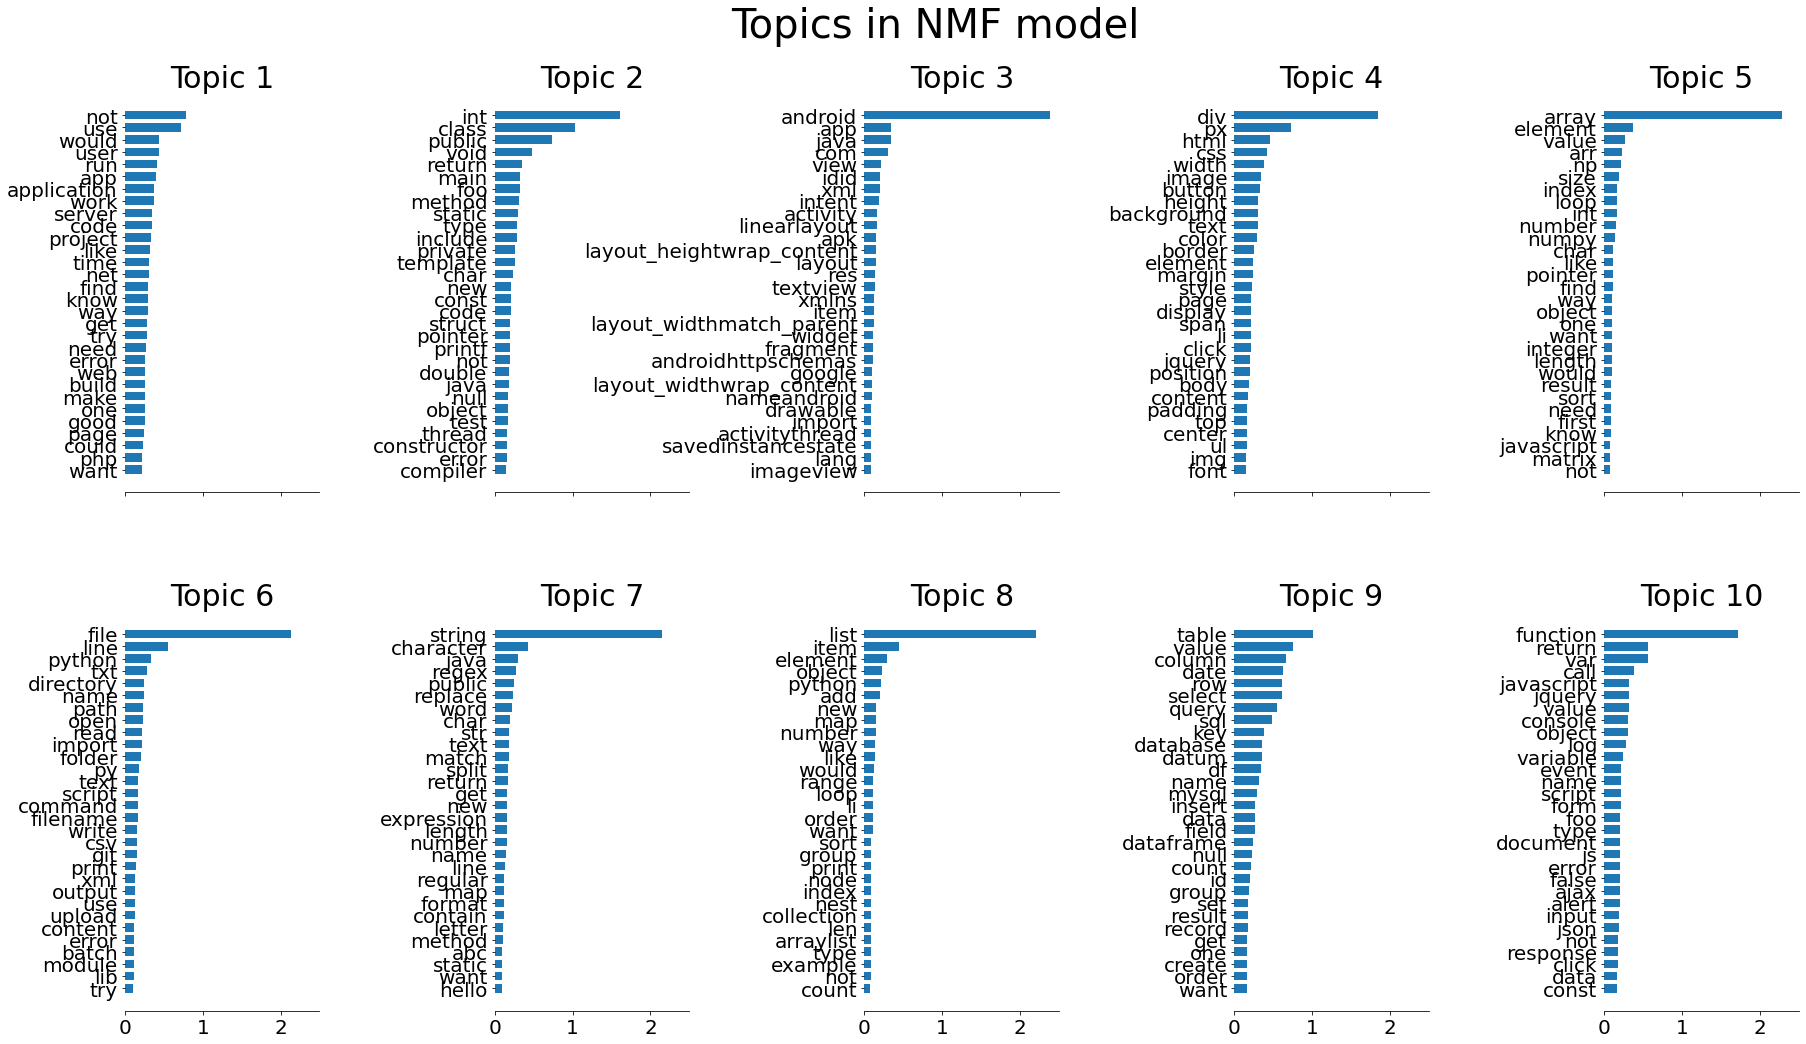

In [18]:
plot_top_words(nmf, tfidf_feature_names, n_top_words=30, title="Topics in NMF model")

### b) Latent Dirichlet Allocation (LDA)

In [19]:
bow_vectorizer = CountVectorizer(ngram_range = (1,1),
                                 tokenizer=tok)
docs_bow = bow_vectorizer.fit_transform(docs)

In [20]:
lda = LatentDirichletAllocation(random_state=42,
                                batch_size=400)

In [21]:
params = {'n_components' : [8, 9, 10],
          "learning_decay" : [0.5, 0.7, 0.9],
          "learning_method" : ["batch", "online"]}

gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5,
                              verbose=2)
gridsearch_lda.fit(docs_bow)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  22.6s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  22.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  22.7s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  21.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  22.1s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  22.1s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  22.1s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  22.6s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  22.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  23.2s
[CV] END learning_decay=0.5, learning_method=batch, n_components=10; 

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(batch_size=400,
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [8, 9, 10]},
             verbose=2)

In [22]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)
print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 8}
Best Log Likelihood Score:  -1864146.8219761632


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, docs_bow, bow_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6     -108.958252 -208.941483       1        1  47.956018
3      186.487061  -98.103249       2        1  31.880298
1       19.245832  160.858780       3        1   8.577695
0      170.658829   75.445076       4        1   4.591600
7       -1.386411  -35.043739       5        1   2.037889
2     -145.800095  106.944611       6        1   1.800045
4       64.834541 -221.825272       7        1   1.741669
5     -196.906036  -58.990913       8        1   1.414786, topic_info=          Term          Freq         Total Category  logprob  loglift
2852   android   3543.000000   3543.000000  Default  30.0000  30.0000
413          ]  15944.000000  15944.000000  Default  29.0000  29.0000
478          _   4811.000000   4811.000000  Default  28.0000  28.0000
1            [  10631.000000  10631.000000  Default  27.0000  27.0000
30490     java   3543.000000   3543.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
6474        br     23.758199    187.913228   Topic8  -6.3502   2.1901
38360      net     27.610450    905.480281   Topic8  -6.1999   0.7679
7621    cancel     17.248174     60.672561   Topic8  -6.6704   3.0004
1545        ad     17.882469     89.525445   Topic8  -6.6343   2.6475
63742        x     22.360741   3517.743010   Topic8  -6.4108  -0.8001

[583 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
0          1  0.027507           9
0          2  0.007641           9
0          4  0.942880           9
0          7  0.021394           9
1          1  0.053143           [
...      ...       ...         ...
64655      6  0.006580           z
64686      6  0.038953  zclpayload
64686      8  0.934870  zclpayload
64853      1  0.013094  zygoteinit
64853      4  0.982037  zygoteinit

[1562 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 2, 1, 8, 3, 5, 6])

- Topic 1 : OS - Top topic
- Topic 2 : Script Language/Python
- Topic 3 : Web language/Front-end
- Topic 4 : Java
- Topic 5 : Web language/Back-end
- Topic 6 : SQL
- Topic 7 : Script Language

## 3) Supervised learning for text classification

### a) Data preparation

In [15]:
tags = data[["Id", "Tags"]]

In [16]:
tags = tags["Tags"].str.split(expand=True)
tags['Id'] = data["Id"]
tags.columns = ["1st", "2nd", "3rd", "4th", "5th", "Id"]
tags = tags[["Id", "1st", "2nd", "3rd", "4th", "5th"]]
tags.head()

,Id,1st,2nd,3rd,4th,5th
73660,1709216,c,yaml,None,None,None
35316,11233449,javascript,twitter-bootstrap,None,None,None
28719,6376571,c#,None,None,None,None
149862,61548934,java,spring-boot,docker,maven,None
13680,2652816,javascript,None,None,None,None


In [17]:
tags.fillna("",inplace=True)

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

new_tags=pd.DataFrame(mlb.fit_transform(tags[["1st", "2nd", "3rd", "4th", "5th"]].values),
                      columns=mlb.classes_,
                      index=tags["Id"])

In [19]:
from sklearn.model_selection import train_test_split

X = docs
y = new_tags

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

In [20]:
vectorizer = TfidfVectorizer(ngram_range =(1,1),
                            tokenizer=tok,
                            max_features=12000)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

In [21]:
X_test_vec = vectorizer.transform(X_test)

### b) Naive Bayes Classifier

In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, 
                                           class_prior=None))
nb_clf.fit(X_train_vec, y_train)

MultiOutputClassifier(estimator=MultinomialNB())

In [23]:
y_pred_nb = nb_clf.predict(X_test_vec)

In [24]:
print_evaluation_scores(y_test, y_pred_nb)

Accuracy:  0
Accuracy (normalized): 0.0
F1-score macro:  0.0002512792766663285
F1-score micro:  0.3532786074572248
F1-score weighted:  0.207523493121508
Precision macro:  nan
Precision micro:  0.19163832654398816
Precision weighted:  0.20929637862543993
Recall macro:  0.0002382777270968931
Recall micro:  0.2223605577689243
Recall weighted:  0.2223605577689243


- Grid Search

In [25]:
from sklearn.metrics import make_scorer, f1_score

scorer_multilabel = make_scorer(f1_score,
                                average="weighted")

In [26]:
from sklearn.model_selection import GridSearchCV

params = {"estimator__alpha": [0.3, 0.5, 0.7, 0.9, 1.0]}

gridsearch_nb = GridSearchCV(estimator=nb_clf, 
                             param_grid=params, 
                             scoring=scorer_multilabel,
                             cv=5,
                             verbose = 2)
gridsearch_nb.fit(X_train_vec, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............................estimator__alpha=0.3; total time=  11.2s
[CV] END ...............................estimator__alpha=0.3; total time=  11.3s
[CV] END ...............................estimator__alpha=0.3; total time=  11.1s
[CV] END ...............................estimator__alpha=0.3; total time=  11.1s
[CV] END ...............................estimator__alpha=0.3; total time=  11.1s
[CV] END ...............................estimator__alpha=0.5; total time=  11.1s
[CV] END ...............................estimator__alpha=0.5; total time=  11.0s
[CV] END ...............................estimator__alpha=0.5; total time=  11.1s
[CV] END ...............................estimator__alpha=0.5; total time=  10.9s
[CV] END ...............................estimator__alpha=0.5; total time=  10.9s
[CV] END ...............................estimator__alpha=0.7; total time=  10.9s
[CV] END ...............................estimator

GridSearchCV(cv=5, estimator=MultiOutputClassifier(estimator=MultinomialNB()),
             param_grid={'estimator__alpha': [0.3, 0.5, 0.7, 0.9, 1.0]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [27]:
gridsearch_nb.best_estimator_

MultiOutputClassifier(estimator=MultinomialNB(alpha=0.3))

In [28]:
gridsearch_nb.best_params_

{'estimator__alpha': 0.3}

In [29]:
best_model_nb = gridsearch_nb.best_estimator_

- Model Evaluation

In [30]:
y_pred_nb = best_model_nb.predict(X_test_vec)

In [31]:
print_evaluation_scores(y_test, y_pred_nb)

Accuracy:  4
Accuracy (normalized): 0.001943634596695821
F1-score macro:  0.0005802890252807655
F1-score micro:  0.3743305092998344
F1-score weighted:  0.23605741915890377
Precision macro:  nan
Precision micro:  0.20619948001068056
Precision weighted:  0.2227948811186951
Recall macro:  0.0004367413920932664
Recall micro:  0.23929282868525897
Recall weighted:  0.23929282868525897


### c) Support Vector Machine

In [32]:
from sklearn.svm import SVC

svm_clf = OneVsRestClassifier(SVC(random_state=42))
svm_clf.fit(X_train_vec, y_train)

ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
y_pred = svm_clf.predict(X_test_vec)

In [ ]:
print_evaluation_scores(y_test, y_pred)

## 4) Machine Learning for Multilabel Classification

### a) Algorithm Adaptation approaches

- MultiLabel SVM

In [59]:
X_train_vec = X_train_vec.toarray()
y_train = np.array(y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [61]:
X_test_vec = X_test_vec.toarray()
y_test = np.array(y_test)

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [57]:
from skmultilearn.adapt import MLTSVM

mlsvm_clf = MLTSVM()
mlsvm_clf.fit(X_train_vec, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'A'

In [60]:
y_pred = mlsvm_clf.predict(X_test_vec)
print_evaluation_scores(y_test, y_pred)

AttributeError: 'MLTSVM' object has no attribute 'wk_norms'

In [ ]:
parameters = {'c_k': [2**i for i in range(-5, 5, 2)]}

gridsearch_mlsvm = GridSearchCV(MLTSVM(), 
                                parameters, 
                                scoring=scorer,
                                cv=5,
                                verbose=2)
gridsearch_mlsvm.fit(X_train_vec, y_train)

print(gridsearch_mlsvm.best_params_, gridsearch_mlsvm.best_score_)

In [ ]:
best_model_mlsvm = gridsearch_mlsvm.best_estimator_

In [ ]:
y_pred = best_model_mlsvm.predict(X_test_vec)
print_evaluation_scores(y_test, y_pred)

- Multilabel KNN

In [38]:
from skmultilearn.adapt import MLkNN

mlknn_clf = MLkNN()

In [39]:
y_pred = mlknn_clf.predict(X_test_vec)
print_evaluation_scores(y_test, y_pred)

AttributeError: 'MLkNN' object has no attribute '_num_labels'

In [43]:
parameters = {'k': range(1,3), 
              's': [0.5, 0.7, 1.0]}


gridsearch_mlknn = GridSearchCV(mlknn_clf, 
                   parameters, 
                   scoring=scorer_multilabel)
gridsearch_mlknn.fit(X_train, y_train)

print (gridsearch_mlknn.best_params_, gridsearch_mlknn.best_score_)

NotFittedError: All estimators failed to fit

In [ ]:
best_model_mlknn = gridsearch_mlknn.best_estimator_

In [ ]:
y_pred = best_model_mlknn.predict(X_test_vec)
print_evaluation_scores(y_test, y_pred)

### b) Problem Transformation approaches¶

In [ ]:
from skmultilearn.problem_transform import ClassifierChain

chain_clf = ClassifierChain(
    classifier = SVC(),
    require_dense = [False, True])

In [ ]:
y_pred = chain_clf.predict(X_test_vec)
print_evaluation_scores(y_test, y_pred)

In [ ]:
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'linear'],
    },
]

gridsearch_chain = GridSearchCV(ClassifierChain(), 
                   parameters, 
                   scoring=scorer_multilabel)

gridsearch_chain.fit(X_train, y_train)

print (gridsearch_chain.best_params_, gridsearch_chain.best_score_)

In [ ]:
best_model_chain = gridsearch_chain.best_estimator_

In [ ]:
y_pred = best_model_chain.predict(X_test_vec)
print_evaluation_scores(y_test, y_pred)

In [ ]:
del data
del new_tag
del tags
gc.collect()

## 5) Deep Learning for text classification

In [ ]:
data = pd.read_csv(path)
data.head(3)

In [ ]:
# remove < and > around Tags
data["Tags"] = data["Tags"].replace({"<" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({">" : " "}, regex=True)

In [ ]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data = data.sample(frac=0.05, random_state=42)

In [ ]:
docs = data["Title"].values + " " + data["Body"].values

In [ ]:
tags = data[["Id", "Tags"]]

In [ ]:
tags = tags["Tags"].str.split(expand=True)
tags['Id'] = data["Id"]
tags.columns = ["1st", "2nd", "3rd", "4th", "5th", "Id"]
tags = tags[["Id", "1st", "2nd", "3rd", "4th", "5th"]]
tags.head()

In [ ]:
tags.fillna("",inplace=True)

In [ ]:
mlb = MultiLabelBinarizer()

new_tags=pd.DataFrame(mlb.fit_transform(tags[["1st", "2nd", "3rd", "4th", "5th"]].values),
                      columns=mlb.classes_,
                      index=tags["Id"])

In [ ]:
X = docs
y = new_tags

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

#### a) Using LSTM

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import convert_to_tensor

In [ ]:
max_sequence_length = 1650

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=12000, output_sequence_length=1650)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

- LSTM

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Bidirectional, Dense, Embedding, Flatten, InputLayer, SpatialDropout1D, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
vocab_size = 12000
embedding_dim = 32
max_length = 1650

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(max_length, )))
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(0.001))

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='illustrations/lstm_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=1)

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print_evaluation_scores(y_test, y_pred)

- Introducing embedding with GloVe

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
path_to_glove_file = 'datasets/glove.840B.300d.txt'

In [ ]:
warnings.filterwarnings("ignore")

embeddings_index = {}
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(max_length, )))
model.add(Embedding(num_tokens,
                    embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False,)
model.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(0.001))

In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='illustrations/lstm_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=1)

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print_evaluation_scores(y_test, y_pred)